In [24]:
# Import required libraries
import sys
if hasattr(sys.stdout, 'reconfigure'): 
    sys.stdout.reconfigure(encoding='utf-8') 

In [25]:
import pandas as pd
import numpy as np
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

 Data Loading and Cleaning


In [26]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [27]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)


In [28]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)


In [29]:
encoder = LabelEncoder()
encoder

LabelEncoder()

In [30]:
df['target'] = encoder.fit_transform(df['target'])

In [31]:
df = df.drop_duplicates(keep='first')


Exploratory Data Analysis


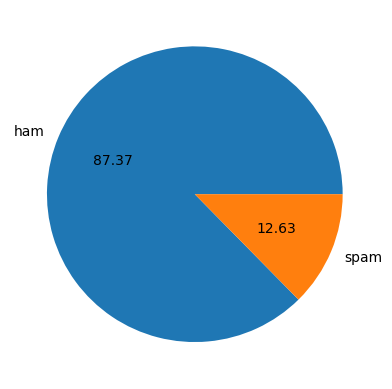

In [32]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Feature Engineering

In [33]:
nltk.download('punkt')
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\user5\AppData\Local\Temp\ipykernel_10280\3055333232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)
C:\Users\user5\AppData\Local\Temp\ipykernel_10280\3055333232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
C:\Users\user5\A

Text Preprocessing

In [34]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

In [35]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]
    text = [ps.stem(word) for word in text]
    return " ".join(text)

df['transformed_text'] = df['text'].apply(transform_text)

C:\Users\user5\AppData\Local\Temp\ipykernel_10280\3891061159.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


Vectorization

In [37]:
tfidf = TfidfVectorizer(max_features=3000)
x = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

Train-Test Split

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


Model Training and Evaluation

In [39]:
clfs = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'SVC': SVC(kernel='sigmoid', gamma=1.0, probability=True),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1'),
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=2),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=2),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=2),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=50, random_state=2),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=50, random_state=2),
    'XGBoost': XGBClassifier(n_estimators=50, random_state=2)
}

accuracy_scores = []
precision_scores = []

def train_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, precision

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, x_train, y_train, x_test, y_test)
    print(f"Classifier: {name}")
    print(f"Accuracy: {current_accuracy}")
    print(f"Precision: {current_precision}")
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

Classifier: GaussianNB
Accuracy: 0.8694390715667312
Precision: 0.5068493150684932
Classifier: MultinomialNB
Accuracy: 0.9709864603481625
Precision: 1.0
Classifier: BernoulliNB
Accuracy: 0.9835589941972921
Precision: 0.991869918699187
Classifier: SVC
Accuracy: 0.9758220502901354
Precision: 0.9747899159663865
Classifier: KNeighbors
Accuracy: 0.9052224371373307
Precision: 1.0
Classifier: DecisionTree
Accuracy: 0.9274661508704062
Precision: 0.8118811881188119
Classifier: LogisticRegression
Accuracy: 0.9584139264990329
Precision: 0.9702970297029703
Classifier: RandomForest
Accuracy: 0.9758220502901354
Precision: 0.9829059829059829


c:\Users\user5\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classifier: AdaBoost
Accuracy: 0.960348162475822
Precision: 0.9292035398230089
Classifier: Bagging
Accuracy: 0.9584139264990329
Precision: 0.8682170542635659
Classifier: ExtraTrees
Accuracy: 0.9748549323017408
Precision: 0.9745762711864406
Classifier: GradientBoosting
Accuracy: 0.9468085106382979
Precision: 0.9191919191919192
Classifier: XGBoost
Accuracy: 0.9671179883945842
Precision: 0.9262295081967213


Voting Classifier

In [40]:
voting = VotingClassifier(estimators=[
    ('svc', clfs['SVC']),
    ('mnb', clfs['MultinomialNB']),
    ('et', clfs['ExtraTrees'])
], voting='soft')
voting.fit(x_train, y_train)
y_pred_voting = voting.predict(x_test)
print("Voting Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Precision:", precision_score(y_test, y_pred_voting))


Voting Classifier
Accuracy: 0.9816247582205029
Precision: 0.9917355371900827


Stacking Classifier

In [41]:
stacking = StackingClassifier(estimators=[
    ('svc', clfs['SVC']),
    ('mnb', clfs['MultinomialNB']),
    ('et', clfs['ExtraTrees'])
], final_estimator=RandomForestClassifier())
stacking.fit(x_train, y_train)
y_pred_stacking = stacking.predict(x_test)
print("Stacking Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("Precision:", precision_score(y_test, y_pred_stacking))

Stacking Classifier
Accuracy: 0.9796905222437138
Precision: 0.9398496240601504


Save Model and Vectorizer

In [42]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(clfs['MultinomialNB'], open('model.pkl', 'wb'))